# 1. Inference on Synthetic data

Author: [Marc Lelarge](https://www.di.ens.fr/~lelarge/)

Date: 04/05

In this notebook, we test our approach on synthetic data.

The problem can be described as follows: we are given a familly of ODEs $y'=h_\theta(y,t)$, where the function $h$ is parametrized by the parameter $\theta$ and a trajectory $z$, the problem is to find the best value of $\theta$ such that $z'\approx h_{\theta}(z,t)$. In order to find the value of $\theta$, we follow an optimization approach based on the tool developed in [Neural Ordinary Differential Equations](https://arxiv.org/abs/1806.07366). Namely, for a distance function $D$ on $\mathbb{R}^d$, we define $L = D(y_\theta -z)$ where $y_\theta$ is the solution of the ODE $y'=h_{\theta}(y,t)$ and we minimize the loss $L$ with respect to $\theta$ with SGD.

Here, to test this approach, we choose a parameter $\theta$ and integrate the ODE to get the trajectory $z$. We show that based on $z$, we are able to retrieve the parameter $\theta$.

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

## a. the IHD Model 

We propose a simple version of the SIR Model at the start of the epidemics. In this case, all the population is susceptible.

The standard SIR model is given by the equations:
\begin{eqnarray}
\dot{S}(t) &=& -\beta S(t) I(t)\\
\dot{I}(t) &=& \beta S(t) I(t) - \gamma I(t) -\nu I(t)\\
\dot{R}(t) &=& \gamma I(t)\\
\dot{D}(t) &=& \nu I(t)
\end{eqnarray}
where $S(t)$, $I(t)$, $R(t)$ and $D(t)$ are, respectively, the fractions of susceptible, infectious, recovered and deceased individuals at time $t$. $\beta$ is the contagion rate, $\gamma$ is the recovery rate and $\nu$ is the death rate.

In the early stage of the epidemics, we make the approximation $S(t) \approx 1$ so that the second equation simplifies to $\dot{I}(t) = \beta I(t) - \gamma I(t) -\nu I(t)$.

We make two other modifications:
- the contagion rate will depend on time $\beta(t)$
- we add a sub-category of the population $H(t)$, the numbers of individuals in hospital at time $t$. We assume that all deceased individuals are first in a hospital.

We obtain the IHD model given by the equations:
\begin{eqnarray}
\dot{I}(t) &=& \beta(t) I(t) -\gamma I(t)-\nu I(t)\\
\dot{R}(t) &=& \gamma I(t)\\
\dot{H}(t) &=& \nu I(t) - \gamma H(t) - \lambda H(t)\\
\dot{D}(t) &=& \lambda H(t)
\end{eqnarray}
note that the recovered individuals can be ignored to compute $I(t),H(t)$ and $D(t)$.

In practice, we will prametrize the function $\beta(t)$ as follows:
$$\beta(t) = \beta_1 +\delta \sigma(t-\tau),$$
where $\sigma(.)$ is the sigmoid function.

In [3]:
from model_epidemio import ihd_fit

In [4]:
size = 101
t = torch.linspace(0., size-1, size)
true_init = torch.tensor([[0.01,0., 0.]])
parms = torch.tensor([0.1,-0.04,0.05,0.015,0.02])
time = torch.tensor([30.])
ihd_synt = ihd_fit.IHD_model(parms,time)

$\beta_1=0.1, \delta = -0.04, \gamma = 0.05, \nu = 0.015, \lambda = 0.02$

$\tau = 30$

$I(0)=0.01, H(0)=0, D(0)=0$

In [5]:
y_synt = ihd_fit.predic_ode(ihd_synt, true_init,t)

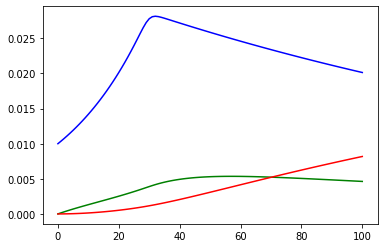

In [6]:
plt.plot(t,y_synt[:,0], 'b')
plt.plot(t,y_synt[:,1], 'g')
plt.plot(t,y_synt[:,2], 'r')

Integration of the ODE: Infected = Blue, Hospital = green, Deaths = red

## b. Inference pb

Now given the trajectory depicted above, we try to recover the parameters of the model.

In [48]:
parms_fit = torch.tensor([0.15,-0.05,0.05,0.05,0.05])
time_fit = torch.tensor([50.])
ihd_time = ihd_fit.IHD_fit_time(parms_fit,time_fit)

In [49]:
optimizer_time = optim.RMSprop([{'params': [ihd_time.b1, ihd_time.b2, ihd_time.g, ihd_time.nu, ihd_time.l]},
                                {'params': ihd_time.time, 'lr' : 1.}], lr=1e-3)
criterion = nn.MSELoss()

best_loss, best_parms = ihd_fit.trainig(ihd_time, init=true_init, t=t, optimizer=optimizer_time,
                                        criterion=criterion,niters=600,data=y_synt)

10 9.737190703162923e-05 [tensor(0.1399), tensor(-0.0597), tensor(0.0603), tensor(0.0598), tensor(0.0354), tensor([39.9936])]
20 8.696584700373933e-05 [tensor(0.1398), tensor(-0.0593), tensor(0.0605), tensor(0.0594), tensor(0.0305), tensor([40.1213])]
30 7.744281174382195e-05 [tensor(0.1399), tensor(-0.0588), tensor(0.0606), tensor(0.0590), tensor(0.0258), tensor([40.3663])]
40 6.874083919683471e-05 [tensor(0.1400), tensor(-0.0582), tensor(0.0606), tensor(0.0584), tensor(0.0215), tensor([40.7014])]
50 6.11956711509265e-05 [tensor(0.1403), tensor(-0.0576), tensor(0.0605), tensor(0.0579), tensor(0.0177), tensor([41.0923])]
60 5.525864617084153e-05 [tensor(0.1405), tensor(-0.0569), tensor(0.0604), tensor(0.0573), tensor(0.0146), tensor([41.4944])]
70 5.1089285989291966e-05 [tensor(0.1407), tensor(-0.0561), tensor(0.0604), tensor(0.0567), tensor(0.0124), tensor([41.8583])]
80 4.835083018406294e-05 [tensor(0.1409), tensor(-0.0554), tensor(0.0604), tensor(0.0561), tensor(0.0111), tensor([42.

In [50]:
ihd_inf = ihd_fit.get_best_model(best_parms)

In [51]:
y_inf = ihd_fit.predic_ode(ihd_inf, true_init,t)

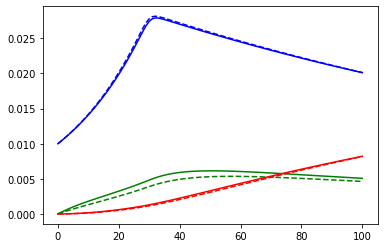

In [52]:
plt.plot(y_inf[:,0], 'b')
plt.plot(y_synt[:,0], 'b--')
plt.plot(y_inf[:,1], 'g')
plt.plot(y_synt[:,1], 'g--')
plt.plot(y_inf[:,2], 'r')
plt.plot(y_synt[:,2], 'r--')

Infected = Blue, Hospital = green, Deaths = red; dashed = true, plain = estimated

In [53]:
for i,p in enumerate(best_parms):
    try: 
        print('true: ', parms[i].item(), 'evaluated: ', p.data.item())
    except:
        print('true: ', time.item(), 'evaluated: ', p.data.item())

true:  0.10000000149011612 evaluated:  0.13568738102912903
true:  -0.03999999910593033 evaluated:  -0.039264485239982605
true:  0.05000000074505806 evaluated:  0.0784379169344902
true:  0.014999999664723873 evaluated:  0.022902600467205048
true:  0.019999999552965164 evaluated:  0.01730191893875599
true:  30.0 evaluated:  30.319229125976562
